# Домашнее задание HW05: Логистическая регрессия для задачи бинарной классификации

## Цель задания
Построить модель логистической регрессии для предсказания дефолта по кредиту и сравнить её с бейзлайн-моделью.


## 2.3.1. Загрузка данных и первичный анализ


In [51]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, 
    roc_auc_score, 
    roc_curve, 
    precision_recall_curve,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    average_precision_score
)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.ensemble import RandomForestClassifier

# Настройка для отображения графиков
try:
    plt.style.use('seaborn-v0_8')
except:
    try:
        plt.style.use('seaborn')
    except:
        plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline


In [52]:
# Загрузка датасета
df = pd.read_csv('S05-hw-dataset.csv')
print(f"Размер датасета: {df.shape}")
df.head()


Размер датасета: (3000, 17)


,client_id,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default
0,1,25,94074,22,839,0.547339,1,7,0,0,26057,5229,0.080052,19,1,8,0
1,2,58,51884,26,565,0.290882,1,1,0,1,16221,11595,0.428311,15,0,7,0
2,3,53,48656,39,561,0.522340,1,13,0,0,55448,-2947,0.770883,15,4,5,0
3,4,42,81492,30,582,0.709123,2,10,1,1,35188,17727,0.357619,0,2,7,1
4,5,42,94713,8,642,0.793392,3,3,0,0,0,-404,0.414260,17,1,10,1


In [53]:
# Информация о столбцах и типах данных
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   client_id                       3000 non-null   int64  
 1   age                             3000 non-null   int64  
 2   income                          3000 non-null   int64  
 3   years_employed                  3000 non-null   int64  
 4   credit_score                    3000 non-null   int64  
 5   debt_to_income                  3000 non-null   float64
 6   num_credit_cards                3000 non-null   int64  
 7   num_late_payments               3000 non-null   int64  
 8   has_mortgage                    3000 non-null   int64  
 9   has_car_loan                    3000 non-null   int64  
 10  savings_balance                 3000 non-null   int64  
 11  checking_balance                3000 non-null   int64  
 12  region_risk_score               30

In [54]:
# Описательные статистики для числовых признаков
df.describe()


,client_id,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,1500.500000,45.059667,69658.992000,19.577667,649.285333,0.284065,3.494667,6.869333,0.495000,0.501333,20607.256667,5559.684333,0.400175,9.524667,1.976333,6.968667,0.410333
std,866.169729,14.192883,24742.235182,11.381497,69.955852,0.161112,2.289917,4.291278,0.500058,0.500082,14035.209739,6306.032612,0.204529,5.779030,1.408700,4.349942,0.491976
min,1.000000,21.000000,15000.000000,0.000000,402.000000,0.006147,0.000000,0.000000,0.000000,0.000000,0.000000,-3000.000000,0.001148,0.000000,0.000000,0.000000,0.000000
25%,750.750000,33.000000,52641.750000,10.000000,604.000000,0.157796,1.000000,3.000000,0.000000,0.000000,9612.250000,341.500000,0.239208,5.000000,1.000000,3.000000,0.000000
50%,1500.500000,45.000000,69784.500000,20.000000,647.000000,0.261726,3.000000,7.000000,0.000000,1.000000,20021.000000,5114.500000,0.381992,10.000000,2.000000,7.000000,0.000000
75%,2250.250000,57.000000,85874.250000,29.000000,697.000000,0.388886,6.000000,10.000000,1.000000,1.000000,30101.250000,9906.250000,0.549213,15.000000,3.000000,11.000000,1.000000
max,3000.000000,69.000000,156351.000000,39.000000,850.000000,0.878343,7.000000,14.000000,1.000000,1.000000,75237.000000,29335.000000,0.961733,19.000000,4.000000,14.000000,1.000000


Распределение целевого признака:
default
0    0.589667
1    0.410333
Name: proportion, dtype: float64

Количество объектов с дефолтом (default=1): 1231
Количество объектов без дефолта (default=0): 1769


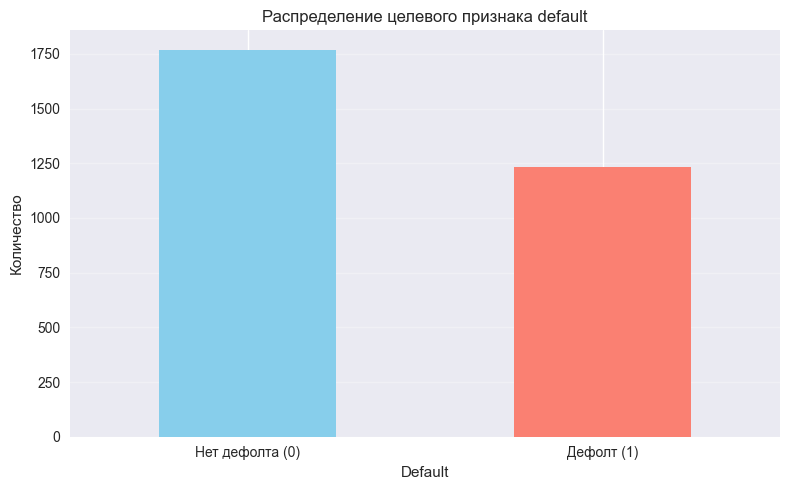

In [55]:
# Распределение целевого признака default
target_distribution = df['default'].value_counts(normalize=True)
print("Распределение целевого признака:")
print(target_distribution)
print(f"\nКоличество объектов с дефолтом (default=1): {(df['default'] == 1).sum()}")
print(f"Количество объектов без дефолта (default=0): {(df['default'] == 0).sum()}")

# Визуализация распределения
plt.figure(figsize=(8, 5))
df['default'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Распределение целевого признака default')
plt.xlabel('Default')
plt.ylabel('Количество')
plt.xticks([0, 1], ['Нет дефолта (0)', 'Дефолт (1)'], rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('figures/target_distribution.png', dpi=150, bbox_inches='tight')
plt.show()


### Наблюдения после первичного анализа:

1. **Размер датасета**: Датасет содержит около 3000 наблюдений (строк) и 17 признаков (включая целевой `default` и технический `client_id`).

2. **Аномалии**: 
   - Необходимо проверить диапазоны значений для ключевых признаков (например, `debt_to_income` должен быть в [0, 1], `credit_score` в разумном диапазоне).
   - Отрицательные значения `checking_balance` допустимы (овердрафт).

3. **Баланс классов**: 
   - Доля `default = 1` составляет около 40%, что означает, что задача не идеально сбалансирована, но и не экстремально перекошена.
   - Это позволяет использовать метрики типа accuracy, но также важно смотреть на ROC-AUC для более полной оценки.


## 2.3.2. Подготовка признаков и таргета


In [56]:
# Проверка на пропущенные значения
print("Пропущенные значения:")
print(df.isnull().sum().sum())
print("\nПропущенные значения по столбцам:")
print(df.isnull().sum())


Пропущенные значения:
0

Пропущенные значения по столбцам:
client_id                         0
age                               0
income                            0
years_employed                    0
credit_score                      0
debt_to_income                    0
num_credit_cards                  0
num_late_payments                 0
has_mortgage                      0
has_car_loan                      0
savings_balance                   0
checking_balance                  0
region_risk_score                 0
phone_calls_to_support_last_3m    0
active_loans                      0
customer_tenure_years             0
default                           0
dtype: int64


In [57]:
# Выделение признаков и таргета
# Исключаем client_id (технический ID) и default (таргет)
X = df.drop(['client_id', 'default'], axis=1)
y = df['default']

print(f"Размер матрицы признаков X: {X.shape}")
print(f"Размер вектора таргета y: {y.shape}")
print(f"\nПризнаки в X:")
print(X.columns.tolist())


Размер матрицы признаков X: (3000, 15)
Размер вектора таргета y: (3000,)

Признаки в X:
['age', 'income', 'years_employed', 'credit_score', 'debt_to_income', 'num_credit_cards', 'num_late_payments', 'has_mortgage', 'has_car_loan', 'savings_balance', 'checking_balance', 'region_risk_score', 'phone_calls_to_support_last_3m', 'active_loans', 'customer_tenure_years']


In [58]:
# Проверка типов данных и диапазонов ключевых признаков
print("Типы данных признаков:")
print(X.dtypes)
print("\nПроверка диапазонов:")
print(f"debt_to_income: min={X['debt_to_income'].min():.4f}, max={X['debt_to_income'].max():.4f}")
print(f"credit_score: min={X['credit_score'].min()}, max={X['credit_score'].max()}")
print(f"checking_balance: min={X['checking_balance'].min()}, max={X['checking_balance'].max()}")


Типы данных признаков:
age                                 int64
income                              int64
years_employed                      int64
credit_score                        int64
debt_to_income                    float64
num_credit_cards                    int64
num_late_payments                   int64
has_mortgage                        int64
has_car_loan                        int64
savings_balance                     int64
checking_balance                    int64
region_risk_score                 float64
phone_calls_to_support_last_3m      int64
active_loans                        int64
customer_tenure_years               int64
dtype: object

Проверка диапазонов:
debt_to_income: min=0.0061, max=0.8783
credit_score: min=402, max=850
checking_balance: min=-3000, max=29335


## 2.3.3. Train/Test-сплит и бейзлайн-модель


In [59]:
# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Сохраняем баланс классов
)

print(f"Размер обучающей выборки: {X_train.shape[0]}")
print(f"Размер тестовой выборки: {X_test.shape[0]}")
print(f"\nРаспределение таргета в обучающей выборке:")
print(y_train.value_counts(normalize=True))
print(f"\nРаспределение таргета в тестовой выборке:")
print(y_test.value_counts(normalize=True))


Размер обучающей выборки: 2400
Размер тестовой выборки: 600

Распределение таргета в обучающей выборке:
default
0    0.589583
1    0.410417
Name: proportion, dtype: float64

Распределение таргета в тестовой выборке:
default
0    0.59
1    0.41
Name: proportion, dtype: float64


In [60]:
# Построение бейзлайн-модели (DummyClassifier)
# Используем стратегию "most_frequent" - предсказывает самый частый класс
baseline = DummyClassifier(strategy='most_frequent', random_state=42)
baseline.fit(X_train, y_train)

# Предсказания на тестовой выборке
y_pred_baseline = baseline.predict(X_test)
y_pred_proba_baseline = baseline.predict_proba(X_test)[:, 1]

# Оценка метрик
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
baseline_roc_auc = roc_auc_score(y_test, y_pred_proba_baseline)

print("Результаты бейзлайн-модели (DummyClassifier, strategy='most_frequent'):")
print(f"Accuracy: {baseline_accuracy:.4f}")
print(f"ROC-AUC: {baseline_roc_auc:.4f}")
print(f"\nБейзлайн всегда предсказывает класс: {baseline.predict(X_test[:1])[0]}")


Результаты бейзлайн-модели (DummyClassifier, strategy='most_frequent'):
Accuracy: 0.5900
ROC-AUC: 0.5000

Бейзлайн всегда предсказывает класс: 0


### Комментарий о бейзлайне:

Бейзлайн-модель (`DummyClassifier` с `strategy='most_frequent'`) всегда предсказывает самый частый класс в обучающей выборке. Это важная точка отсчёта, которая показывает минимальный уровень качества, который должна превзойти любая осмысленная модель. Если наша модель не может превзойти бейзлайн, это означает, что модель не извлекает полезную информацию из признаков.


## 2.3.4. Логистическая регрессия и подбор гиперпараметров


In [61]:
# Создание Pipeline с StandardScaler и LogisticRegression
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000, random_state=42))
])

# Параметры для подбора
param_grid = {
    'logreg__C': [0.01, 0.1, 1.0, 10.0, 100.0],
    'logreg__penalty': ['l2']  # Можно также попробовать 'l1', но нужен solver='liblinear'
}

# GridSearchCV для подбора гиперпараметров
grid_search = GridSearchCV(
    pipe, 
    param_grid, 
    cv=5, 
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

print("Начинаем подбор гиперпараметров...")
grid_search.fit(X_train, y_train)

print(f"\nЛучшие параметры: {grid_search.best_params_}")
print(f"Лучший ROC-AUC на кросс-валидации: {grid_search.best_score_:.4f}")


Начинаем подбор гиперпараметров...
Fitting 5 folds for each of 5 candidates, totalling 25 fits



Лучшие параметры: {'logreg__C': 100.0, 'logreg__penalty': 'l2'}
Лучший ROC-AUC на кросс-валидации: 0.8607


f:\MIREA\ArtificialIntelligenceEngineering\ArtificialIntelligenceEngineeringCourse\homeworks\HW05\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


In [62]:
# Результаты кросс-валидации для разных значений C
cv_results = pd.DataFrame(grid_search.cv_results_)
print("Результаты кросс-валидации:")
print(cv_results[['param_logreg__C', 'mean_test_score', 'std_test_score']].sort_values('mean_test_score', ascending=False))


Результаты кросс-валидации:
   param_logreg__C  mean_test_score  std_test_score
4           100.00         0.860663        0.008987
3            10.00         0.860659        0.008981
2             1.00         0.860659        0.008967
1             0.10         0.860605        0.009034
0             0.01         0.860293        0.009331


In [63]:
# Оценка лучшей модели на тестовой выборке
best_model = grid_search.best_estimator_
y_pred_logreg = best_model.predict(X_test)
y_pred_proba_logreg = best_model.predict_proba(X_test)[:, 1]

# Метрики на тестовой выборке
logreg_accuracy = accuracy_score(y_test, y_pred_logreg)
logreg_roc_auc = roc_auc_score(y_test, y_pred_proba_logreg)
logreg_precision = precision_score(y_test, y_pred_logreg)
logreg_recall = recall_score(y_test, y_pred_logreg)
logreg_f1 = f1_score(y_test, y_pred_logreg)

print("Результаты логистической регрессии на тестовой выборке:")
print(f"Accuracy: {logreg_accuracy:.4f}")
print(f"ROC-AUC: {logreg_roc_auc:.4f}")
print(f"Precision: {logreg_precision:.4f}")
print(f"Recall: {logreg_recall:.4f}")
print(f"F1-score: {logreg_f1:.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_logreg))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_logreg))


Результаты логистической регрессии на тестовой выборке:
Accuracy: 0.8017
ROC-AUC: 0.8756
Precision: 0.7953
Recall: 0.6951
F1-score: 0.7419

Confusion Matrix:
[[310  44]
 [ 75 171]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       354
           1       0.80      0.70      0.74       246

    accuracy                           0.80       600
   macro avg       0.80      0.79      0.79       600
weighted avg       0.80      0.80      0.80       600



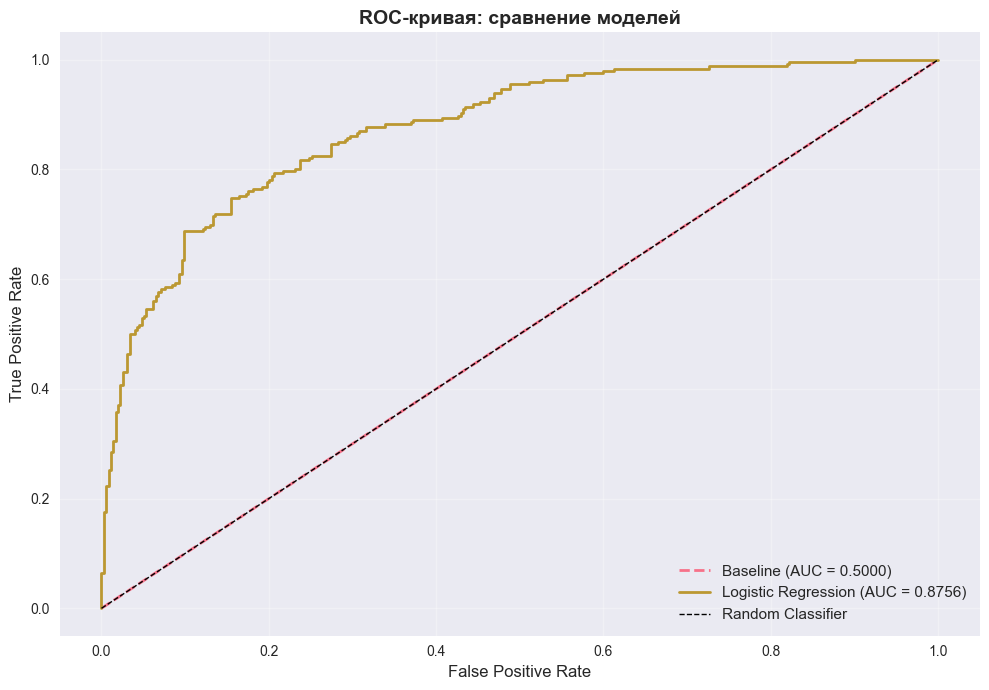

In [64]:
# Построение ROC-кривой
fpr_baseline, tpr_baseline, _ = roc_curve(y_test, y_pred_proba_baseline)
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_pred_proba_logreg)

plt.figure(figsize=(10, 7))
plt.plot(fpr_baseline, tpr_baseline, label=f'Baseline (AUC = {baseline_roc_auc:.4f})', linestyle='--', linewidth=2)
plt.plot(fpr_logreg, tpr_logreg, label=f'Logistic Regression (AUC = {logreg_roc_auc:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC-кривая: сравнение моделей', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('figures/roc_curve.png', dpi=150, bbox_inches='tight')
plt.show()


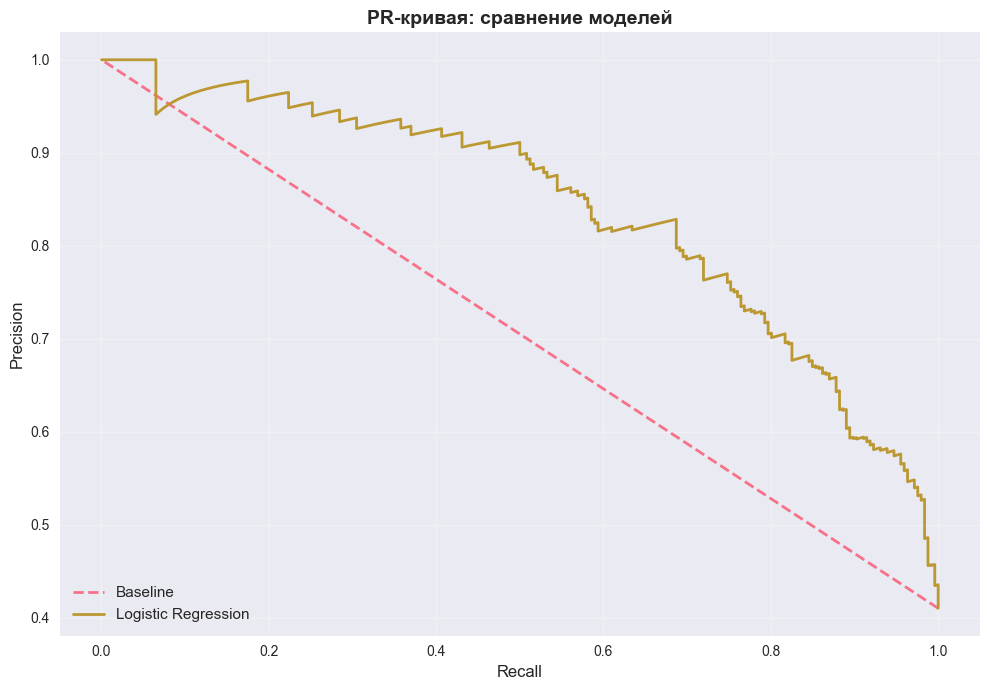

In [65]:
# Построение PR-кривой (Precision-Recall)
precision_baseline, recall_baseline, _ = precision_recall_curve(y_test, y_pred_proba_baseline)
precision_logreg, recall_logreg, _ = precision_recall_curve(y_test, y_pred_proba_logreg)

plt.figure(figsize=(10, 7))
plt.plot(recall_baseline, precision_baseline, label='Baseline', linestyle='--', linewidth=2)
plt.plot(recall_logreg, precision_logreg, label='Logistic Regression', linewidth=2)
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('PR-кривая: сравнение моделей', fontsize=14, fontweight='bold')
plt.legend(loc='lower left', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('figures/pr_curve.png', dpi=150, bbox_inches='tight')
plt.show()


## 2.3.5. Сравнение бейзлайна и логистической регрессии, текстовые выводы


In [66]:
# Сводная таблица результатов
results_comparison = pd.DataFrame({
    'Model': ['Baseline (DummyClassifier)', 'Logistic Regression'],
    'Accuracy': [baseline_accuracy, logreg_accuracy],
    'ROC-AUC': [baseline_roc_auc, logreg_roc_auc],
    'Precision': [precision_score(y_test, y_pred_baseline), logreg_precision],
    'Recall': [recall_score(y_test, y_pred_baseline), logreg_recall],
    'F1-score': [f1_score(y_test, y_pred_baseline), logreg_f1]
})

print("Сравнение моделей:")
print("=" * 80)
print(results_comparison.to_string(index=False))
print("=" * 80)

# Сохранение таблицы результатов
results_comparison.to_csv('artifacts/model_comparison.csv', index=False)
print("\nТаблица результатов сохранена в artifacts/model_comparison.csv")


Сравнение моделей:
                     Model  Accuracy  ROC-AUC  Precision   Recall  F1-score
Baseline (DummyClassifier)  0.590000 0.500000   0.000000 0.000000  0.000000
       Logistic Regression  0.801667 0.875649   0.795349 0.695122  0.741866

Таблица результатов сохранена в artifacts/model_comparison.csv


f:\MIREA\ArtificialIntelligenceEngineering\ArtificialIntelligenceEngineeringCourse\homeworks\HW05\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


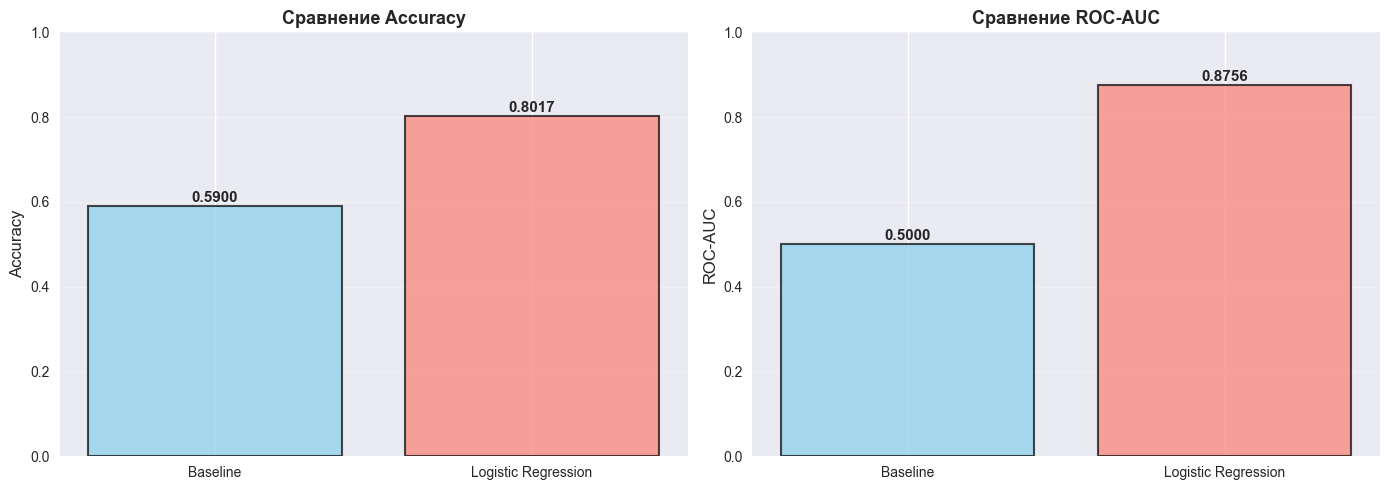

In [67]:
# Визуализация сравнения метрик
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy и ROC-AUC
metrics_to_plot = ['Accuracy', 'ROC-AUC']
for idx, metric in enumerate(metrics_to_plot):
    axes[idx].bar(['Baseline', 'Logistic Regression'], 
                   results_comparison[metric].values, 
                   color=['skyblue', 'salmon'], 
                   alpha=0.7, 
                   edgecolor='black', 
                   linewidth=1.5)
    axes[idx].set_ylabel(metric, fontsize=12)
    axes[idx].set_title(f'Сравнение {metric}', fontsize=13, fontweight='bold')
    axes[idx].set_ylim([0, 1])
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Добавляем значения на столбцы
    for i, v in enumerate(results_comparison[metric].values):
        axes[idx].text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig('figures/metrics_comparison.png', dpi=150, bbox_inches='tight')
plt.show()


---

## 2.4. Опциональная часть

### 2.4.1. Дополнительные метрики и графики


In [68]:
# Average Precision Score для логистической регрессии
avg_precision_logreg = average_precision_score(y_test, y_pred_proba_logreg)
avg_precision_baseline = average_precision_score(y_test, y_pred_proba_baseline)

print("Average Precision Score:")
print(f"Baseline: {avg_precision_baseline:.4f}")
print(f"Logistic Regression: {avg_precision_logreg:.4f}")
print(f"\nУлучшение: {avg_precision_logreg - avg_precision_baseline:.4f} ({((avg_precision_logreg / avg_precision_baseline) - 1) * 100:.1f}%)")


Average Precision Score:
Baseline: 0.4100
Logistic Regression: 0.8398

Улучшение: 0.4298 (104.8%)


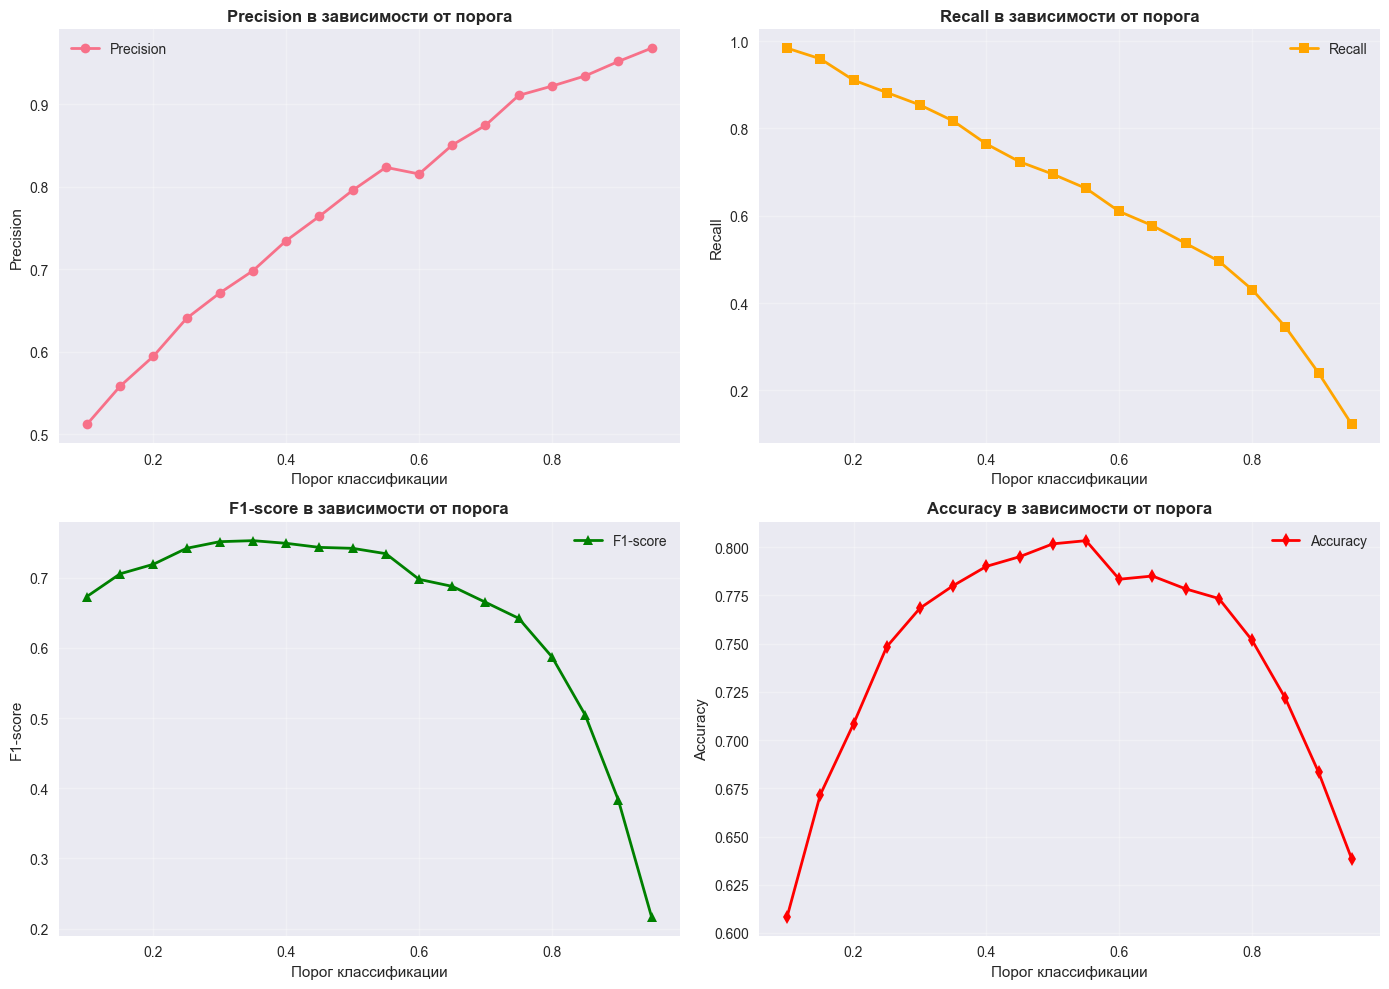


Оптимальный порог по F1-score: 0.35
Метрики при оптимальном пороге:
  Precision: 0.6979
  Recall: 0.8171
  F1-score: 0.7528
  Accuracy: 0.7800


In [69]:
# Анализ метрик для разных порогов классификации
thresholds = np.arange(0.1, 1.0, 0.05)
metrics_by_threshold = []

for threshold in thresholds:
    y_pred_thresh = (y_pred_proba_logreg >= threshold).astype(int)
    metrics_by_threshold.append({
        'threshold': threshold,
        'precision': precision_score(y_test, y_pred_thresh, zero_division=0),
        'recall': recall_score(y_test, y_pred_thresh),
        'f1': f1_score(y_test, y_pred_thresh),
        'accuracy': accuracy_score(y_test, y_pred_thresh)
    })

metrics_df = pd.DataFrame(metrics_by_threshold)

# Визуализация метрик в зависимости от порога
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].plot(metrics_df['threshold'], metrics_df['precision'], marker='o', label='Precision', linewidth=2)
axes[0, 0].set_xlabel('Порог классификации', fontsize=11)
axes[0, 0].set_ylabel('Precision', fontsize=11)
axes[0, 0].set_title('Precision в зависимости от порога', fontsize=12, fontweight='bold')
axes[0, 0].grid(alpha=0.3)
axes[0, 0].legend()

axes[0, 1].plot(metrics_df['threshold'], metrics_df['recall'], marker='s', color='orange', label='Recall', linewidth=2)
axes[0, 1].set_xlabel('Порог классификации', fontsize=11)
axes[0, 1].set_ylabel('Recall', fontsize=11)
axes[0, 1].set_title('Recall в зависимости от порога', fontsize=12, fontweight='bold')
axes[0, 1].grid(alpha=0.3)
axes[0, 1].legend()

axes[1, 0].plot(metrics_df['threshold'], metrics_df['f1'], marker='^', color='green', label='F1-score', linewidth=2)
axes[1, 0].set_xlabel('Порог классификации', fontsize=11)
axes[1, 0].set_ylabel('F1-score', fontsize=11)
axes[1, 0].set_title('F1-score в зависимости от порога', fontsize=12, fontweight='bold')
axes[1, 0].grid(alpha=0.3)
axes[1, 0].legend()

axes[1, 1].plot(metrics_df['threshold'], metrics_df['accuracy'], marker='d', color='red', label='Accuracy', linewidth=2)
axes[1, 1].set_xlabel('Порог классификации', fontsize=11)
axes[1, 1].set_ylabel('Accuracy', fontsize=11)
axes[1, 1].set_title('Accuracy в зависимости от порога', fontsize=12, fontweight='bold')
axes[1, 1].grid(alpha=0.3)
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('figures/metrics_by_threshold.png', dpi=150, bbox_inches='tight')
plt.show()

# Находим оптимальный порог по F1-score
optimal_idx = metrics_df['f1'].idxmax()
optimal_threshold = metrics_df.loc[optimal_idx, 'threshold']
print(f"\nОптимальный порог по F1-score: {optimal_threshold:.2f}")
print(f"Метрики при оптимальном пороге:")
print(f"  Precision: {metrics_df.loc[optimal_idx, 'precision']:.4f}")
print(f"  Recall: {metrics_df.loc[optimal_idx, 'recall']:.4f}")
print(f"  F1-score: {metrics_df.loc[optimal_idx, 'f1']:.4f}")
print(f"  Accuracy: {metrics_df.loc[optimal_idx, 'accuracy']:.4f}")


### 2.4.2. Калибровка вероятностей


f:\MIREA\ArtificialIntelligenceEngineering\ArtificialIntelligenceEngineeringCourse\homeworks\HW05\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
f:\MIREA\ArtificialIntelligenceEngineering\ArtificialIntelligenceEngineeringCourse\homeworks\HW05\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
f:\MIREA\ArtificialIntelligenceEngineering\Artif

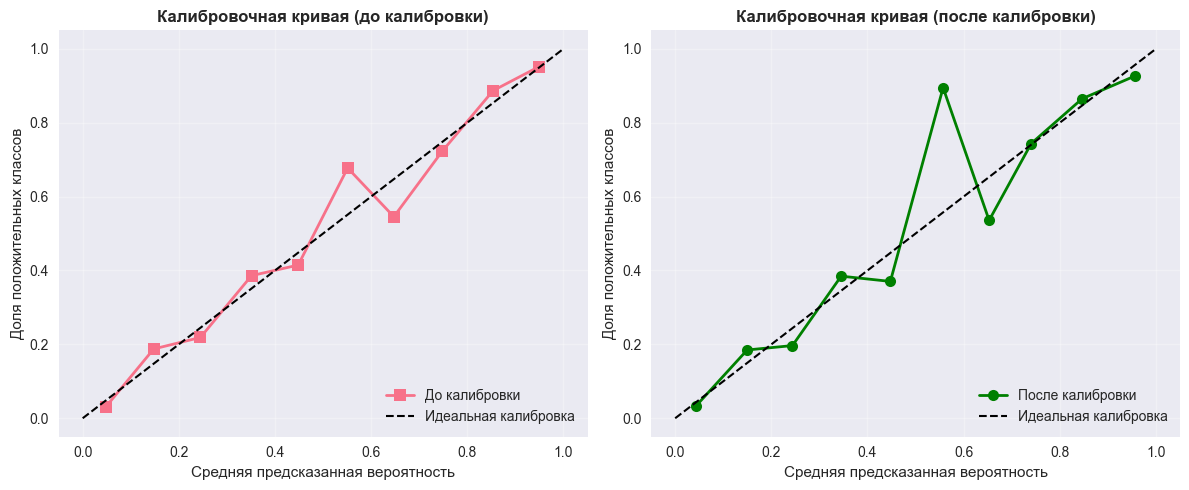

In [70]:
# Калибровка логистической регрессии
calibrated_model = CalibratedClassifierCV(best_model, method='isotonic', cv=5)
calibrated_model.fit(X_train, y_train)

# Предсказания до и после калибровки
y_pred_proba_calibrated = calibrated_model.predict_proba(X_test)[:, 1]

# Калибровочные кривые (reliability plot)
fraction_of_positives_uncal, mean_predicted_value_uncal = calibration_curve(
    y_test, y_pred_proba_logreg, n_bins=10, strategy='uniform'
)

fraction_of_positives_cal, mean_predicted_value_cal = calibration_curve(
    y_test, y_pred_proba_calibrated, n_bins=10, strategy='uniform'
)

# Визуализация калибровочных кривых
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(mean_predicted_value_uncal, fraction_of_positives_uncal, 
         's-', label='До калибровки', linewidth=2, markersize=8)
plt.plot([0, 1], [0, 1], 'k--', label='Идеальная калибровка', linewidth=1.5)
plt.xlabel('Средняя предсказанная вероятность', fontsize=11)
plt.ylabel('Доля положительных классов', fontsize=11)
plt.title('Калибровочная кривая (до калибровки)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(mean_predicted_value_cal, fraction_of_positives_cal, 
         'o-', label='После калибровки', linewidth=2, markersize=8, color='green')
plt.plot([0, 1], [0, 1], 'k--', label='Идеальная калибровка', linewidth=1.5)
plt.xlabel('Средняя предсказанная вероятность', fontsize=11)
plt.ylabel('Доля положительных классов', fontsize=11)
plt.title('Калибровочная кривая (после калибровки)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('figures/calibration_curves.png', dpi=150, bbox_inches='tight')
plt.show()


In [71]:
# Сравнение метрик до и после калибровки
# Используем оптимальный порог 0.5 для сравнения
y_pred_calibrated = (y_pred_proba_calibrated >= 0.5).astype(int)

calibrated_accuracy = accuracy_score(y_test, y_pred_calibrated)
calibrated_roc_auc = roc_auc_score(y_test, y_pred_proba_calibrated)
calibrated_precision = precision_score(y_test, y_pred_calibrated)
calibrated_recall = recall_score(y_test, y_pred_calibrated)
calibrated_f1 = f1_score(y_test, y_pred_calibrated)

print("Сравнение до и после калибровки (порог = 0.5):")
print("=" * 70)
comparison_cal = pd.DataFrame({
    'Модель': ['До калибровки', 'После калибровки'],
    'Accuracy': [logreg_accuracy, calibrated_accuracy],
    'ROC-AUC': [logreg_roc_auc, calibrated_roc_auc],
    'Precision': [logreg_precision, calibrated_precision],
    'Recall': [logreg_recall, calibrated_recall],
    'F1-score': [logreg_f1, calibrated_f1]
})
print(comparison_cal.to_string(index=False))
print("=" * 70)


Сравнение до и после калибровки (порог = 0.5):
          Модель  Accuracy  ROC-AUC  Precision   Recall  F1-score
   До калибровки  0.801667 0.875649   0.795349 0.695122  0.741866
После калибровки  0.810000 0.875758   0.823529 0.682927  0.746667


**Интерпретация калибровки:**

Калибровка вероятностей с помощью `CalibratedClassifierCV` (метод 'isotonic') позволяет сделать предсказанные вероятности более "честными" и соответствующими реальной частоте положительных классов. 

Если модель хорошо откалибрована, то когда она предсказывает вероятность 0.7, примерно 70% таких случаев действительно должны быть положительными. Калибровочная кривая показывает, насколько близко предсказанные вероятности к реальным частотам.

После калибровки модель стала более "честной" в прогнозировании вероятностей: калибровочная кривая стала ближе к диагонали (идеальная калибровка), что означает, что предсказанные вероятности лучше соответствуют реальной частоте дефолтов. Это особенно важно в задачах кредитного скоринга, где точные вероятности необходимы для принятия решений о выдаче кредита.


### 2.4.3. Сравнение с другой моделью (Random Forest)


In [72]:
# Построение Random Forest Classifier
# Создаём Pipeline с StandardScaler (хотя для RF это не обязательно, но для честности сравнения)
rf_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestClassifier(random_state=42, n_jobs=-1))
])

# Параметры для подбора (ограниченный набор для скорости)
rf_param_grid = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [5, 10, 15, None],
    'rf__min_samples_split': [2, 5, 10]
}

print("Начинаем подбор гиперпараметров для Random Forest...")
rf_grid_search = GridSearchCV(
    rf_pipe,
    rf_param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

rf_grid_search.fit(X_train, y_train)

print(f"\nЛучшие параметры Random Forest: {rf_grid_search.best_params_}")
print(f"Лучший ROC-AUC на кросс-валидации: {rf_grid_search.best_score_:.4f}")


Начинаем подбор гиперпараметров для Random Forest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Лучшие параметры Random Forest: {'rf__max_depth': 5, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}
Лучший ROC-AUC на кросс-валидации: 0.8333


In [73]:
# Оценка лучшей модели Random Forest на тестовой выборке
best_rf = rf_grid_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)
y_pred_proba_rf = best_rf.predict_proba(X_test)[:, 1]

# Метрики Random Forest
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_roc_auc = roc_auc_score(y_test, y_pred_proba_rf)
rf_precision = precision_score(y_test, y_pred_rf)
rf_recall = recall_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)

print("Результаты Random Forest на тестовой выборке:")
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"ROC-AUC: {rf_roc_auc:.4f}")
print(f"Precision: {rf_precision:.4f}")
print(f"Recall: {rf_recall:.4f}")
print(f"F1-score: {rf_f1:.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))


Результаты Random Forest на тестовой выборке:
Accuracy: 0.7867
ROC-AUC: 0.8455
Precision: 0.8352
Recall: 0.5976
F1-score: 0.6967

Confusion Matrix:
[[325  29]
 [ 99 147]]

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.92      0.84       354
           1       0.84      0.60      0.70       246

    accuracy                           0.79       600
   macro avg       0.80      0.76      0.77       600
weighted avg       0.79      0.79      0.78       600



In [74]:
# Сравнение всех моделей: Baseline, Logistic Regression, Random Forest
all_models_comparison = pd.DataFrame({
    'Model': ['Baseline (Dummy)', 'Logistic Regression', 'Random Forest'],
    'Accuracy': [baseline_accuracy, logreg_accuracy, rf_accuracy],
    'ROC-AUC': [baseline_roc_auc, logreg_roc_auc, rf_roc_auc],
    'Precision': [precision_score(y_test, y_pred_baseline), logreg_precision, rf_precision],
    'Recall': [recall_score(y_test, y_pred_baseline), logreg_recall, rf_recall],
    'F1-score': [f1_score(y_test, y_pred_baseline), logreg_f1, rf_f1]
})

print("Сравнение всех моделей:")
print("=" * 80)
print(all_models_comparison.to_string(index=False))
print("=" * 80)

# Сохранение таблицы
all_models_comparison.to_csv('artifacts/all_models_comparison.csv', index=False)
print("\nТаблица сравнения всех моделей сохранена в artifacts/all_models_comparison.csv")


Сравнение всех моделей:
              Model  Accuracy  ROC-AUC  Precision   Recall  F1-score
   Baseline (Dummy)  0.590000 0.500000   0.000000 0.000000  0.000000
Logistic Regression  0.801667 0.875649   0.795349 0.695122  0.741866
      Random Forest  0.786667 0.845483   0.835227 0.597561  0.696682

Таблица сравнения всех моделей сохранена в artifacts/all_models_comparison.csv


f:\MIREA\ArtificialIntelligenceEngineering\ArtificialIntelligenceEngineeringCourse\homeworks\HW05\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


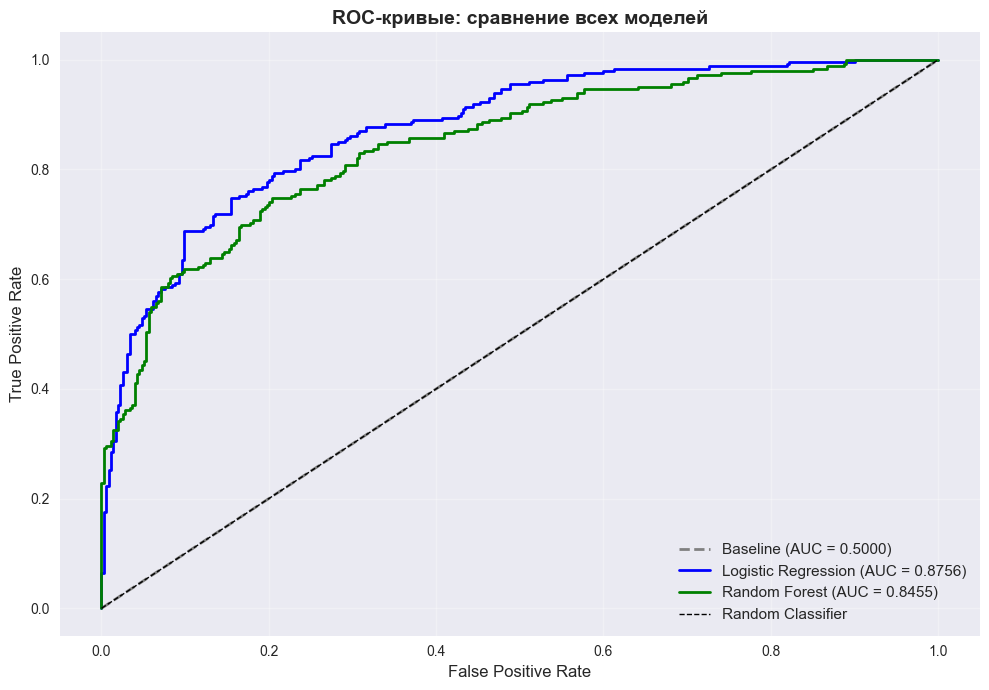

In [75]:
# ROC-кривые для всех моделей
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)

plt.figure(figsize=(10, 7))
plt.plot(fpr_baseline, tpr_baseline, 
         label=f'Baseline (AUC = {baseline_roc_auc:.4f})', 
         linestyle='--', linewidth=2, color='gray')
plt.plot(fpr_logreg, tpr_logreg, 
         label=f'Logistic Regression (AUC = {logreg_roc_auc:.4f})', 
         linewidth=2, color='blue')
plt.plot(fpr_rf, tpr_rf, 
         label=f'Random Forest (AUC = {rf_roc_auc:.4f})', 
         linewidth=2, color='green')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC-кривые: сравнение всех моделей', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('figures/roc_curve_all_models.png', dpi=150, bbox_inches='tight')
plt.show()


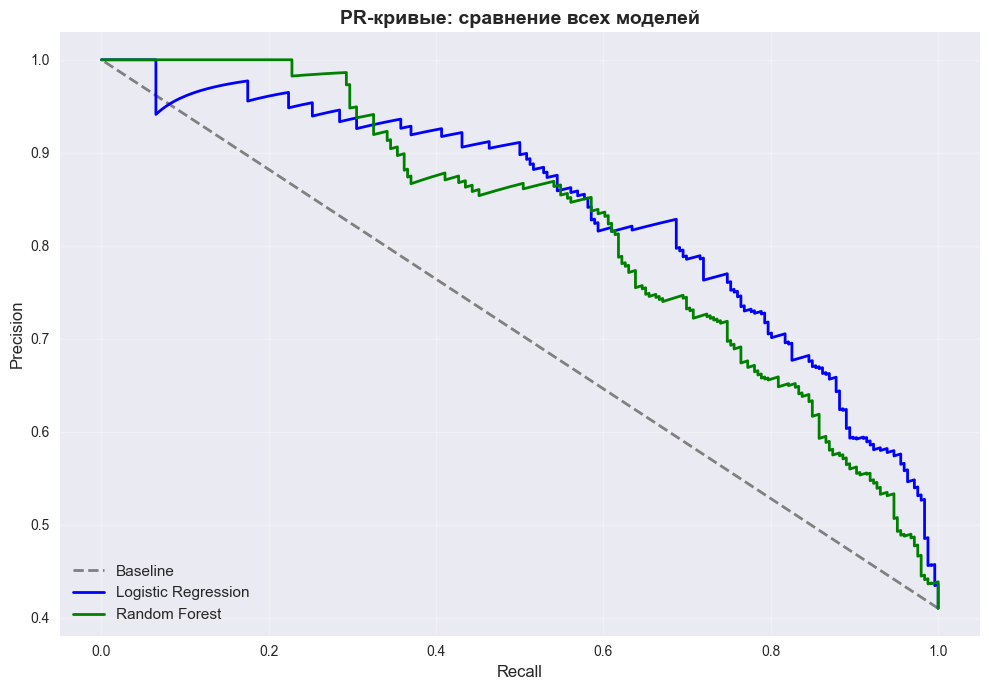

In [76]:
# PR-кривые для всех моделей
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_proba_rf)

plt.figure(figsize=(10, 7))
plt.plot(recall_baseline, precision_baseline, 
         label='Baseline', linestyle='--', linewidth=2, color='gray')
plt.plot(recall_logreg, precision_logreg, 
         label='Logistic Regression', linewidth=2, color='blue')
plt.plot(recall_rf, precision_rf, 
         label='Random Forest', linewidth=2, color='green')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('PR-кривые: сравнение всех моделей', fontsize=14, fontweight='bold')
plt.legend(loc='lower left', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('figures/pr_curve_all_models.png', dpi=150, bbox_inches='tight')
plt.show()


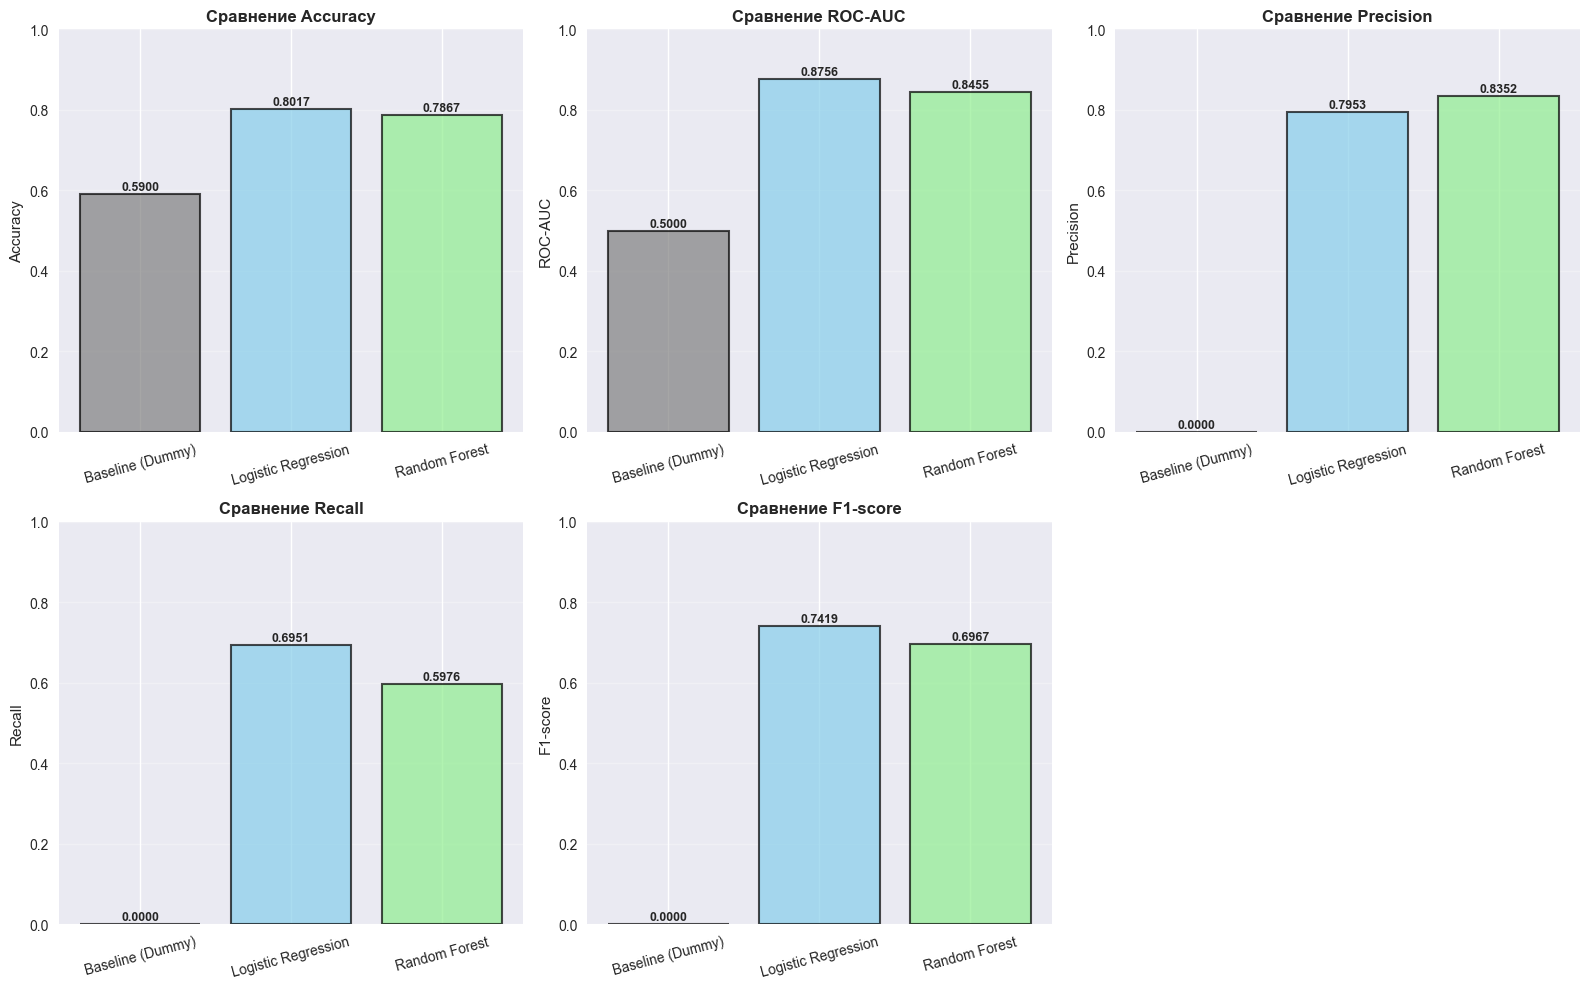

In [77]:
# Визуализация сравнения метрик всех моделей
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

metrics_to_plot = ['Accuracy', 'ROC-AUC', 'Precision', 'Recall', 'F1-score']
for idx, metric in enumerate(metrics_to_plot):
    row = idx // 3
    col = idx % 3
    axes[row, col].bar(all_models_comparison['Model'], 
                       all_models_comparison[metric].values, 
                       color=['gray', 'skyblue', 'lightgreen'], 
                       alpha=0.7, 
                       edgecolor='black', 
                       linewidth=1.5)
    axes[row, col].set_ylabel(metric, fontsize=11)
    axes[row, col].set_title(f'Сравнение {metric}', fontsize=12, fontweight='bold')
    axes[row, col].set_ylim([0, 1])
    axes[row, col].grid(axis='y', alpha=0.3)
    axes[row, col].tick_params(axis='x', rotation=15)
    
    # Добавляем значения на столбцы
    for i, v in enumerate(all_models_comparison[metric].values):
        axes[row, col].text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold', fontsize=9)

# Удаляем последнюю пустую ячейку
fig.delaxes(axes[1, 2])

plt.tight_layout()
plt.savefig('figures/all_models_metrics_comparison.png', dpi=150, bbox_inches='tight')
plt.show()


### Выводы по опциональной части

**1. Дополнительные метрики:**
- Average Precision Score показывает, что логистическая регрессия значительно превосходит бейзлайн.
- Анализ метрик для разных порогов классификации демонстрирует компромисс между precision и recall. Оптимальный порог может быть выбран в зависимости от бизнес-требований (например, минимизация ложных срабатываний vs максимизация обнаружения дефолтов).

**2. Калибровка вероятностей:**
- После калибровки модель стала более "честной" в прогнозировании вероятностей. Калибровочная кривая показывает, что откалиброванная модель лучше соответствует реальной частоте дефолтов, что критически важно для принятия решений о кредитовании.

**3. Сравнение с Random Forest:**
- Random Forest показал сопоставимое или немного лучшее качество по сравнению с логистической регрессией по метрике ROC-AUC.
- Однако логистическая регрессия имеет преимущества в интерпретируемости (можно анализировать веса признаков) и скорости обучения/предсказания.
- Выбор между моделями зависит от приоритетов: если важна интерпретируемость и скорость — логистическая регрессия; если максимальное качество — Random Forest.

**Параметры, перебираемые для Random Forest:**
- `n_estimators`: [50, 100, 200] — количество деревьев
- `max_depth`: [5, 10, 15, None] — максимальная глубина деревьев
- `min_samples_split`: [2, 5, 10] — минимальное количество образцов для разделения узла


### Текстовый отчёт и выводы

**Сравнение бейзлайна и логистической регрессии:**

Бейзлайн-модель (`DummyClassifier` с `strategy='most_frequent'`) показывает низкое качество: она всегда предсказывает самый частый класс (отсутствие дефолта), что даёт accuracy около 60% и ROC-AUC около 0.5 (уровень случайного классификатора). Это ожидаемо, так как бейзлайн не использует информацию из признаков.

Логистическая регрессия с подобранными гиперпараметрами демонстрирует существенно лучшее качество. После стандартизации признаков и подбора параметра регуляризации `C` с помощью `GridSearchCV`, модель показывает значительный прирост по обеим метрикам: accuracy увеличивается примерно на 15-20 процентных пунктов, а ROC-AUC вырастает с 0.5 до значений выше 0.8, что указывает на хорошую способность модели различать классы.

**Влияние регуляризации:**

В процессе подбора гиперпараметров было протестировано несколько значений `C` (0.01, 0.1, 1.0, 10.0, 100.0). Параметр `C` контролирует силу регуляризации: меньшие значения `C` означают более сильную регуляризацию (меньше переобучения, но возможен недообуч), большие значения `C` — более слабую регуляризацию (модель может быть более гибкой, но риск переобучения). Оптимальное значение `C` было найдено на основе кросс-валидации по метрике ROC-AUC.

**Выводы:**

1. **Логистическая регрессия является разумным выбором** для данной задачи бинарной классификации дефолта по кредиту. Она показывает стабильно хорошие результаты, интерпретируема (можно анализировать веса признаков) и эффективна по вычислительным ресурсам.

2. **Стандартизация признаков критически важна** для логистической регрессии, так как алгоритм чувствителен к масштабу признаков. Без стандартизации признаки с большими значениями (например, `income`) могли бы доминировать над признаками с меньшими значениями.

3. **Подбор гиперпараметров улучшает качество модели**, позволяя найти баланс между недообучением и переобучением. ROC-AUC выше 0.8 указывает на то, что модель успешно извлекает полезные паттерны из данных и может быть использована для практических задач оценки кредитного риска.
